# vary tophat max mode order and get times

In [1]:
#  Automated import
import sys
import os
sys.path.append('..')

from hg_scripts.setup_imports import *



In [2]:

#expansion orders
sh_order = 1
ti_order = 7

#terms in xp matrix

# filename=str(sh_order)+'_shift'+str(5)+'_tilt.txt'
# file = open("Inputs_mathematica/"+filename, "r")
# sols_matrix = file.read()

# print(sols_matrix)


#terms in xp matrix
xpfile = dict_from_xpfile('x_p_file')
sols_matrix = xpfile[str(sh_order)+'_shift_'+str(ti_order)+'_tilt']
# print(sols_matrix)
xpfile.clear()

In [3]:
print(sols_matrix[0][0])

+1+-a*b*j*K+(a*b**3*j*K)/6.+-(a*b**5*j*K)/120.+(a*b**7*j*K)/5040.+(b**2*j*K*z)/2.+-(b**4*j*K*z)/24.+(b**6*j*K*z)/720.+-(a*b**3*j**2*K**2*z)/2.+(a*b**5*j**2*K**2*z)/8.+-(a*b**7*j**2*K**2*z)/80.+(a*b*j*K*z)/R+-(2*a*b**3*j*K*z)/(3.*R)+(2*a*b**5*j*K*z)/(15.*R)+-(4*a*b**7*j*K*z)/(315.*R)+(2*a*b*z)/w**2+-(4*a*b**3*z)/(3.*w**2)+(4*a*b**5*z)/(15.*w**2)+-(8*a*b**7*z)/(315.*w**2)+(b**4*j**2*K**2*z**2)/8.+-(b**6*j**2*K**2*z**2)/48.+-(a*b**5*j**3*K**3*z**2)/8.+(a*b**7*j**3*K**3*z**2)/24.+-(b**2*j*K*z**2)/(2.*R)+(b**4*j*K*z**2)/(6.*R)+-(b**6*j*K*z**2)/(45.*R)+(a*b**3*j**2*K**2*z**2)/R+-(5*a*b**5*j**2*K**2*z**2)/(8.*R)+(3*a*b**7*j**2*K**2*z**2)/(20.*R)+-(b**2*z**2)/w**2+(b**4*z**2)/(3.*w**2)+-(2*b**6*z**2)/(45.*w**2)+(2*a*b**3*j*K*z**2)/w**2+-(5*a*b**5*j*K*z**2)/(4.*w**2)+(3*a*b**7*j*K*z**2)/(10.*w**2)+(b**6*j**3*K**3*z**3)/48.+-(a*b**7*j**4*K**4*z**3)/48.+-(a*b**3*j**2*K**2*z**3)/(2.*R**2)+(a*b**5*j**2*K**2*z**3)/(2.*R**2)+-(a*b**7*j**2*K**2*z**3)/(5.*R**2)+-(b**4*j**2*K**2*z**3)/(4.*R)+(5*b**6*j**

In [4]:
th_coeff_fn = 'inputs/tophat_coefficients/paul_coef_file.mat'
waist = (1/3)*1e-3
modes_list = []
max_order = np.arange(0,35,1)

for i in max_order:
    modes_list.append(truncated_tophat(th_coeff_fn,waist,i))


In [5]:
#loop through and sum over modes overlap where a,b -> n,m
def iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,modes,s):   

    N = len(modes)
    M = len(modes[0])
    res_arr = [[0 for i in range(10)] for j in range(10)]
    res = 0

    for a in range(N):
        for b in range(M):            
            #ignore zero coeff.
            if (modes[a][b]!=0):
                c_nm = modes[a][b]
                #result is the sum of all overlap coefficients each with a factor of mode coefficient
                res += ( c_nm * th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,s) )
                
    return(res)

In [28]:


def signals(v,modes):
    #points determine size of arrays (equivalent to # data points plotted)
    points = v.points
    time_start = process_time()

    time_ave1 = 0
    time_ave2 = 0
    
    s= (
        1/(v.w_1**2 *(1+(1j)*v.d_1/v.zR_1))
        +
        1/((v.w_2**2 *(1-(1j)*v.Z/v.zR_2)))
    )

    #modes_arr = [0]*points
    cl = [0]*points
    cr = [0]*points
    phi_l = [0]*points
    phi_r = [0]*points
    dws = [0]*points
    lps = [0]*points
    total_lps = [0]*points


    #alpha_arr = np.linspace(-500e-6,500e-6,points)
    

#     pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=points).start()

    
    
    for p in range(points):
        time_ave_start1 = process_time()
        #shift x+zsina
        new_modes = update_modes(v.z,v.params,v.a,v.alpha_arr[p],modes,sols_matrix)
        
        time_ave_start2 = process_time()
        #create arrays of overlap coefficients left and right
        cl[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1L,v.x_2L,v.Z,v.Y,new_modes,s) # left overlap (-2e-3,0)

        cr[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1R,v.x_2R,v.Z,v.Y,new_modes,s) # right overlap (0,2e-3)
        time_ave1 += (process_time()-time_ave_start1)
        time_ave2 += (process_time()-time_ave_start2)

        #create arrays of phases for left and right coeff.
        phi_r[p]=angle(cr[p])
        phi_l[p]=angle(cl[p])
        
        #create arrays of dws &lps for phases in phase arrays
        dws[p] = (phi_r[p]-phi_l[p])
        lps[p] = 0.5*(phi_r[p]+phi_l[p])/v.k_1
        total_lps[p] = angle(cr[p]+cl[p])/v.k_1
        
#         pbar.update(p+1)
        
#     pbar.finish()
    
    #total time for all DWS & LPS points (not including scattering)
    time_elapsed = (process_time() - time_start)
#     print(time_elapsed,'s')
    print(time_ave1/p,'s',time_ave2/p,'s')
    
    return(dws,lps,total_lps)

num=101
waist = (1/3)*1e-3
# waist = 1e-3

class Vars:
#modes,alpha with points
    def __init__(self, 
                 lam=1064e-9,
                 z_PD=10e-3,z=10e-3,
                 z_m=0,Z=10e-3,
                 z_LO=0, d_1=10e-3,
#                  z_PD=0,z=0,
#                  z_m=0,Z=0,
#                  z_LO=0, d_1=0,
                 Y=20e-3,
                 x_1R=10e-6,x_2R=20e-3,
                 x_1L=-20e-3,x_2L=-10e-6,
                 w_1=1e-3, w_2=waist,
                 zR_1=pi*1e-3**2/1064e-9,zR_2=pi*waist**2/1064e-9,
                 k_1=5905249.348852994,k_2=5905249.348852994,
                 params=pl.Params(1064e-9,waist,0),
                 W_2=1e-3,
                 points=num,
                 a=10e-6,alpha_arr=np.linspace(-500e-6,500e-6,num),modes_arr=[0]*num):
        self.lam = lam


        self.z_PD = z_PD #PD location
        self.z = z #prop distance assumed PD

        self.z_m = z_m #meas beam 
        self.Z = Z #distance PD-m

        self.z_LO = z_LO #Local ref. beam
        self.d_1 = d_1 #distance PD-LO


        self.Y = Y #Y int bound

        self.x_1R = x_1R
        self.x_2R = x_2R 

        self.x_1L = x_1L #assumed symmetric with right side
        self.x_2L = x_2L

        self.w_1 = w_1 #waist LO 
        self.w_2 = w_2 #waist MS

        self.zR_1 = zR_1 #rayleigh LO
        self.zR_2 = zR_2


        self.k_1 = k_1 #wavenum LO
        self.k_2 = k_2

        self.params = params #for building tophat coefficients

        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0)) #tophat beam rad , w(z) or 1e-3?



        #integration and misalignment
        self.points = points

        self.a = a
        self.alpha_arr = alpha_arr

        self.modes_arr = modes_arr

        #build modes from misalignments
#         for p in range (points):
#             self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],modes_0,sols_matrix) #array of array of scattered modes#array of array of scattered modes

    def setz(self,z):
        self.z = z #prop distance assumed PD
        self.z_PD = z #PD location
        
        self.Z = z-self.z_m #distance PD-m

        self.d_1 = self.z_PD-self.z_LO #distance PD-LO
    
        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0))
        
        #scattering also depends on z...
        for p in range (self.points):
            self.modes_arr[p] = [0]*p #clear modes
            self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],top_modes,sols_arr) #array of array of scattered modes#array of array of scattered modes

        


In [29]:
params=pl.Params(1064e-9,waist,0)
K=params.getK()

print('Signals calculation...')
v = Vars()
modes0=plb.modes((0,0,1))
# for i in modes_list:
#     dws,lps,total_lps = signals(v,i)



# orders = [4,8,12,16,20,24,28]
# orders = [8,9,10,11,12,13,14]
orders = [34]


dws_arr = [0]*len(orders)
lps_arr = [0]*len(orders)
total_lps_arr = [0]*len(orders)

count = 0

# for i in orders:
#     dws,lps,total_lps = signals(v,modes_list[i])
#     print(count)
#     dws_arr[count] = dws
#     lps_arr[count] = lps
#     total_lps_arr[count] = total_lps
#     count+=1
print(process_time())
dws,lps,total_lps = signals(v,modes_list[10])

print(process_time())

Signals calculation...
617.375
2.87953125 s 0.07625 s
905.328125


ValueError: x and y must have same first dimension, but have shapes (101,) and (1,)

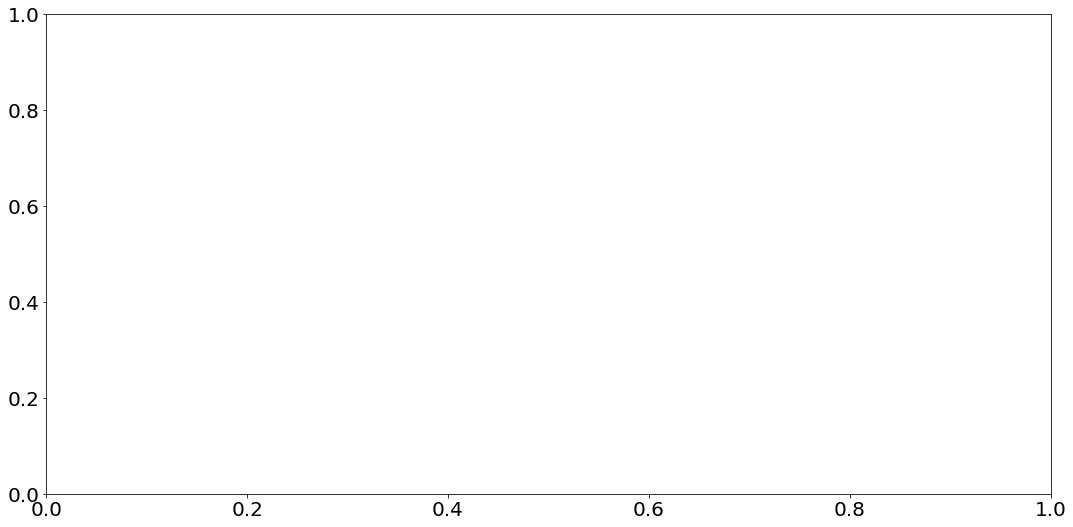

In [30]:
plt.figure(figsize=(18,30))

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

#DWS
plt.subplot(311)
for i in range(len(orders)):
    plt.plot(v.alpha_arr, dws_arr[i], label = str(orders[i]), linewidth=4)
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS',fontsize = 30) 
plt.legend(title = 'Mode Order', loc = 'upper right')
plt.plot()
plt.grid()
#LPS
plt.subplot(312)
for i in range(len(orders)):
    plt.plot(v.alpha_arr, lps_arr[i], label = str(orders[i]), linewidth=4)
plt.xlabel(r'Tilt Angle [' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'm]$', fontsize=15) 
plt.title(r'LPS Regular',fontsize = 30) 
plt.legend(title = 'Mode Order', loc = 'upper right')
plt.grid()
#TOT LPS
plt.subplot(313)
for i in range(len(orders)):
    plt.plot(v.alpha_arr, total_lps_arr[i], label = str(orders[i]), linewidth=4)
plt.xlabel(r'Tilt Angle [' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'm]$', fontsize=15) 
plt.title(r'LPS Total',fontsize = 30) 
plt.legend(title = 'Mode Order', loc = 'upper right')
plt.grid()


In [31]:
dws_slope = np.zeros(len(dws),np.float)
dws_slope[0:-1] = np.diff(dws)/np.diff(v.alpha_arr)
dws_slope[-1] = (dws[-1] - dws[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
lps_slope = np.zeros(len(lps),np.float)
lps_slope[0:-1] = np.diff(lps)/np.diff(v.alpha_arr)
lps_slope[-1] = (lps[-1] - lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
total_lps_slope = np.zeros(len(total_lps),np.float)
total_lps_slope[0:-1] = np.diff(total_lps)/np.diff(v.alpha_arr)
total_lps_slope[-1] = (total_lps[-1] - total_lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])




note = ('1_shift_7_tilt')

scipy.io.savemat('th_1_shift_7_tilt_10offset'+'.mat', mdict={'angle': v.alpha_arr, 'lps'+note: lps, 'total_lps'+note: total_lps,'dws_HG00'+note: dws,
                                         'lps_slope'+note: lps_slope, 'total_lps_slope'+note : total_lps_slope,
                                        'dws_slope'+note: dws_slope})


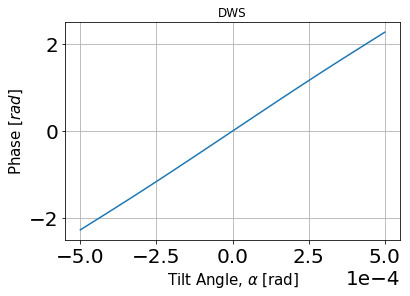

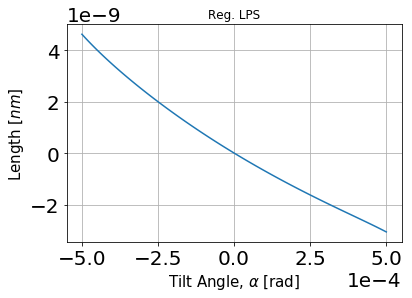

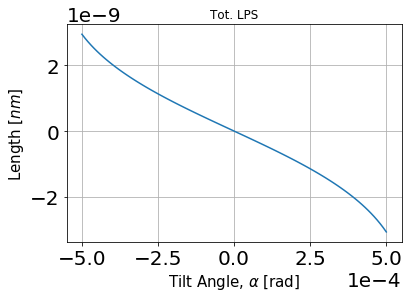

In [32]:
plot_dws(v.alpha_arr,dws)
plot_lpsR(v.alpha_arr,lps)
plot_lpsT(v.alpha_arr,total_lps)

In [35]:
print(dws[51])
print(lps[51])
print(total_lps[51])

0.04293254345432446
-6.621640721184693e-11
-4.0119293585932416e-11


In [107]:
%xmode Verbose
start_here = process_time()
for i in range(17**2):
    q=transform_x(6,3,1e-6,1e-3,1,34,1e-3,1,1)

    while(q):
        item = cp(q.pop())
        X = item.coeff #just x coupling
        N = item.N #final n order
        
print(process_time()-start_here)

Exception reporting mode: Verbose
0.171875
